In [47]:
#Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import seaborn as sns
import matplotlib.patches as mpatches


from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics


In [48]:
#To remove warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

In [49]:
#seaborn configuration
sns.set(rc={'figure.figsize':(10,5)}) 
sns.set_style('whitegrid')
sns.set_palette ("Set1")
#sns.set(rc={'figure.figsize':(11.7,8.27)})



## Load data

In [50]:
#file = "data/old/combined_dataframe.csv"
#df = pd.read_csv(file, sep = '\t')  

In [51]:
df_2019 = pd.read_csv("data/2019.csv", sep = '\t')  
df_2020 = pd.read_csv("data/2020.csv", sep = '\t')  
df_2021 = pd.read_csv("data/2021.csv", sep = '\t')  
df_2022 = pd.read_csv("data/2022.csv", sep = '\t') 


In [52]:
df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [53]:
df.to_csv('data/combined_dataframe.csv', index=False, header=True, sep ='\t' )

### Number of races 

In [54]:
print("Number rows dataframe: ")
print(len(df))

Number rows dataframe: 
82523


### Change/add variables

In [55]:
def change_add_var(df):
    # Change the colum HasPitLap, to check if in the next lap it made the lap, and change name to PitNextLap
    
    #Is changing in the current lap, needs to change in the next
    df["NumberPitStops"] = df.groupby(["Year", "RaceNumber", "Driver"])["NumberPitStops"].shift(1).fillna(0)

    #Data from previus lap
    df["TimeLap"] = df.groupby(["Year", "RaceNumber", "Driver"])["TimeLap"].shift(1).fillna(0)

    return df

In [56]:
df = change_add_var(df)

### Remove variables 

In [57]:
# the data was compiled, but then was not useful 
def remonve_var(df):
    df = df.drop(['DriverNumber'], axis=1)
    df = df.drop(['DriverAhead'], axis=1)
    df = df.drop(['DriverBehind'], axis=1)
    df = df.drop(['TimePit'], axis=1)
    return df

In [58]:
df = remonve_var(df)

## Pit stops info 

In [59]:
df["HasPitLap"].value_counts()/df.shape[0]


0.0    0.967888
1.0    0.031870
Name: HasPitLap, dtype: float64

In [60]:
df["GoodPitStop"].value_counts()/df.shape[0]


0    0.983386
1    0.016614
Name: GoodPitStop, dtype: float64

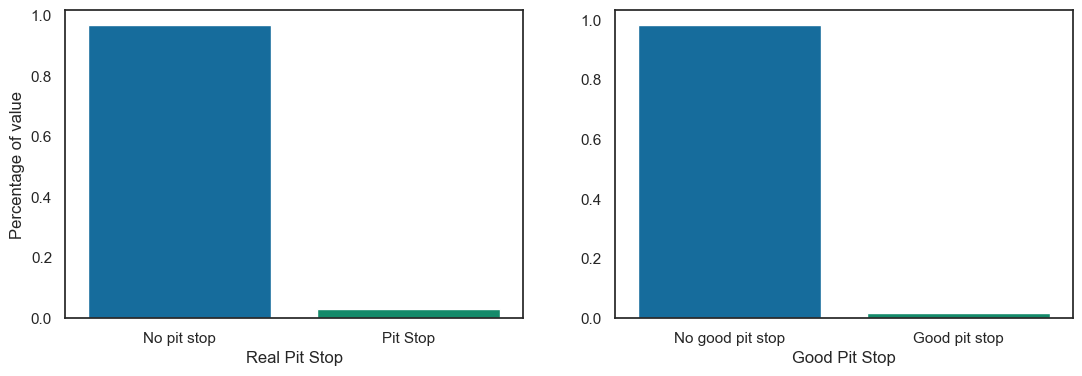

In [61]:
# Create figure with two subplots
#palette = {0: 'blue', 1: 'green'}
my_palette = ["#0072B2", "#009E73"]
sns.set_style('white')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 4))

# Plot first bar plot for GoodPitStop variable
value_counts1 = df["HasPitLap"].value_counts()/df.shape[0]
sns.barplot(x=value_counts1.index, y=value_counts1.values, ax=ax1, palette=my_palette)
ax1.set_ylabel('Percentage of value')
ax1.set_xlabel('Real Pit Stop')

# Plot second bar plot for HasPitLap variable
value_counts2 = df["GoodPitStop"].value_counts()/df.shape[0]
sns.barplot(x=value_counts2.index, y=value_counts2.values, ax=ax2, palette=my_palette)
ax2.set_ylabel('')
ax2.set_xlabel('Good Pit Stop')

ax1.set_xticklabels(['No pit stop', 'Pit Stop'])
ax2.set_xticklabels(['No good pit stop', 'Good pit stop'])

plt.show()


# Data cleaning

### Pit stops por faster lap

In [62]:
def remove_FastestLap(df):
    number_fl = 0
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if (val.iloc[-3:]['HasPitLap'] == 1).any():
                    df = df.drop(val.index)
                    number_fl +=1 
    
    print (number_fl)
    return df

In [63]:
df = remove_FastestLap (df)

55


## Rainy races
Races with rain, i.e. those in which intermediate or wet tires are used, are eliminated. 

### Plot

In [64]:
#For the spa race in 2021 we have some 'UNKNOWN' values, remove them 
df = df[df['Compound'] != 'UNKNOWN']


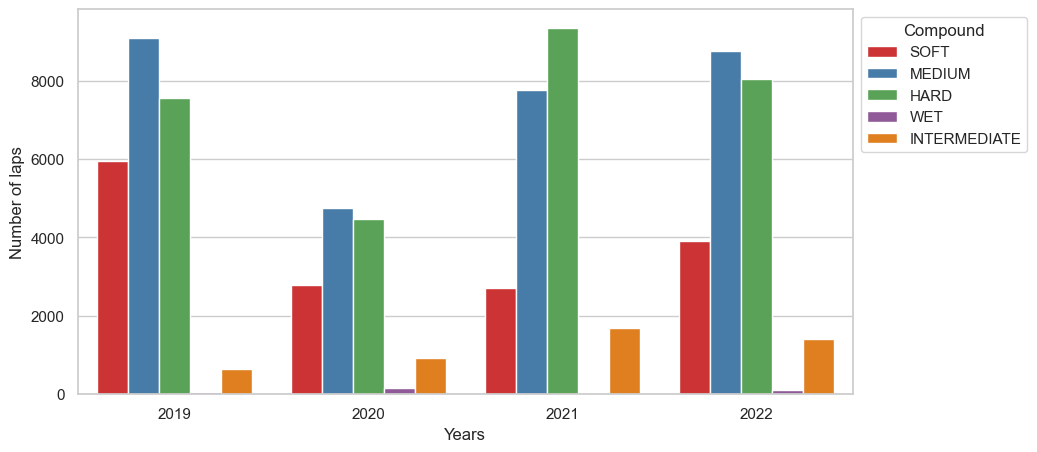

In [65]:
sns.set_style('whitegrid')

value_counts = df.groupby('Year')['Compound'].value_counts()
all_values = pd.MultiIndex.from_product([df['Year'].unique(), df['Compound'].unique()])
value_counts = value_counts.reindex(all_values, fill_value=0)

value_counts = value_counts.reset_index()
value_counts.columns = ['Year', 'Compound', "Value"]

# Set y-label to "number of laps"
plot = sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts)
plot.set_ylabel('Number of laps')
plot.set_xlabel('Years')
plt.legend(title='Compound', bbox_to_anchor=(1, 1))

### Deleted 

In [66]:
def remove_rain(df):
    #Initialized in 1, because I have removed by hand spa in 2021 already gave an error 
    initial_races = 0
    rain_races= 0 
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            initial_races+=1
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]
            #If in that race any driver uses Intermediate or wet tyres, delete the all the sace
            if ('INTERMEDIATE' in val['Compound'].values or 'WET' in val['Compound'].values):
                rain_races +=1
                df = df.drop(val.index)

    print("Total races in the DataSet: " + str(initial_races))
    print("Number of races that have been eliminated due to rain: " + str(rain_races))

    return (df)


In [67]:
df = remove_rain(df)

Total races in the DataSet: 77
Number of races that have been eliminated due to rain: 12


## Remove laps per time

In [68]:
v_date= ['TimeLap', 'TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader'] # 'TimePit'
#TODO

def remove_time (df):
    #Convert the times to secods 
    df['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
    df['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
    df['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
    df['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()


    df = df.drop(df[df['TimeLap']> 240].index)
    df = df.drop(df[df['TimeDiffToLeader']> 210].index)
    df = df.drop(df[df['TimeDiffAhead']> 60].index)
    df = df.drop(df[df['TimeDiffBehind']> 60].index)
    return df

In [69]:
#df = remove_time(df)
#TODO

## Retired or more than 4 stops 

In [70]:
def remove_retired(df):
    list_remove = pd.DataFrame()
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ('Finished' != val["ResultStatus"].iloc[0] and '+1 Lap' != val["ResultStatus"].iloc[0] and '+2 Laps' != val["ResultStatus"].iloc[0]):
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': val["ResultStatus"].iloc[0]}, ignore_index=True)
                    df = df.drop(val.index) 
                    #TODO
                elif val["NumberPitStops"].iloc[-1] >4:  
                    list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': "+4 pit stops"}, ignore_index=True)
                    df = df.drop(val.index)
    
    return df, list_remove

In [71]:
df, list_remove = remove_retired(df)


### Plot

Text(0.5, 0, 'Reason for deleted')

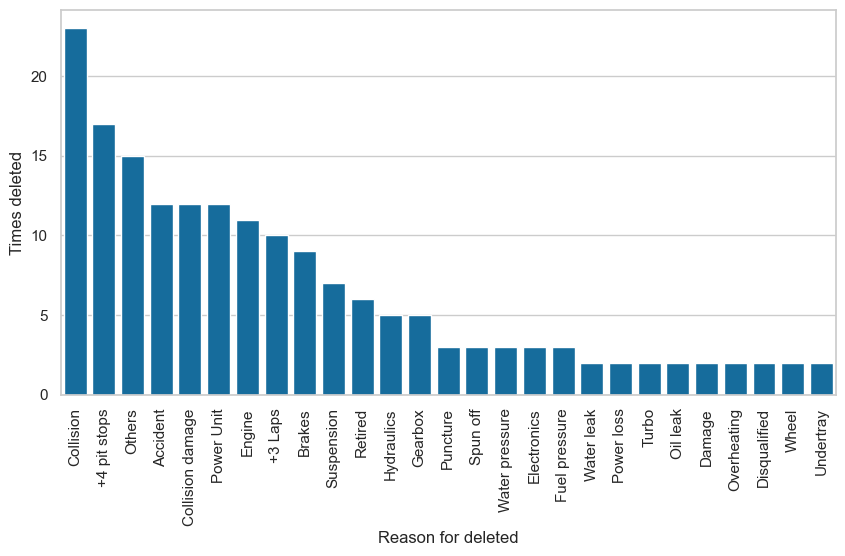

In [72]:
sns.set_style('whitegrid')
my_palette = ["#0072B2"]

value_counts = list_remove["problem"].value_counts()

#plot
fig, ax = plt.subplots(figsize=(10, 5))


# Find values that occur only once
single_counts = value_counts[value_counts == 1].index
# Replace single-count values with 'others'
list_remove["problem"] = list_remove["problem"].replace(single_counts, "Others")
# Count the occurrences of each value in the modified Series
value_counts = list_remove["problem"].value_counts()

ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=my_palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Times deleted')
ax.set_xlabel('Reason for deleted')

## Null values

In [73]:
null_cols = df.columns[df.isnull().any()]
print(null_cols)

Index(['QualyPosition', 'DriverStandings'], dtype='object')


In [74]:
def remove_null (df): 
    #Qualy Position and GridPosition
    for year in df['Year'].unique():
        for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
            for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
                val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
                if ( np.isnan(val["QualyPosition"].iloc[0])):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "QualyPosition"] = val["Position"].iloc[0]
                if ( val["GridPosition"].iloc[0] == 0):
                    df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "GridPosition"] = val["Position"].iloc[0]
    
    #DriverStandings
    df['DriverStandings'] = df['DriverStandings'].fillna(0)

    return df

In [75]:
df = remove_null (df)

### Export df

In [76]:
df.to_csv('data/combined_dataframe_clean.csv', index=False, header=True, sep ='\t' )

## Final number laps

In [77]:
print("Number rows dataframe after preprocesing: ")
print(len(df))

Number rows dataframe after preprocesing: 
62566


In [78]:
df = df.reset_index(drop=True)  # Reset the index labels

# Data Visualization

In [79]:
v_categorical= ['Year', 'RaceName', 'Driver', 'Team', 'Compound', 'TrackStatus'] #'TrackStatus' is categorical, but make in a different way 

v_numerical = ['RaceNumber', 'GridPosition', 'LapNumber', 'TyreLife', 
               'QualyPosition', 'DriverStandings', 'Position',
               'NumberPitStops']
v_binary = ['TyresChange','DriverAheadPit', 'DriverBehindPit' ]
v_date= ['TimeLap', 'TimeDiffAhead', 'TimeDiffBehind', 'TimeDiffToLeader'] 

### Categorical

In [80]:
#Create DF for track status
trackStatus_encoded = pd.DataFrame()
df['TrackStatus'] = df['TrackStatus'].astype(str)
for num in range(1, 8):
    col_name = 'Status ' + str(num)
    trackStatus_encoded[col_name] = df['TrackStatus'].str.contains(str(num)).astype(int)
    
# create a new DataFrame with the count of each column
count_trackStatus = trackStatus_encoded.sum().reset_index()
count_trackStatus.columns = ['column_name', 'count']


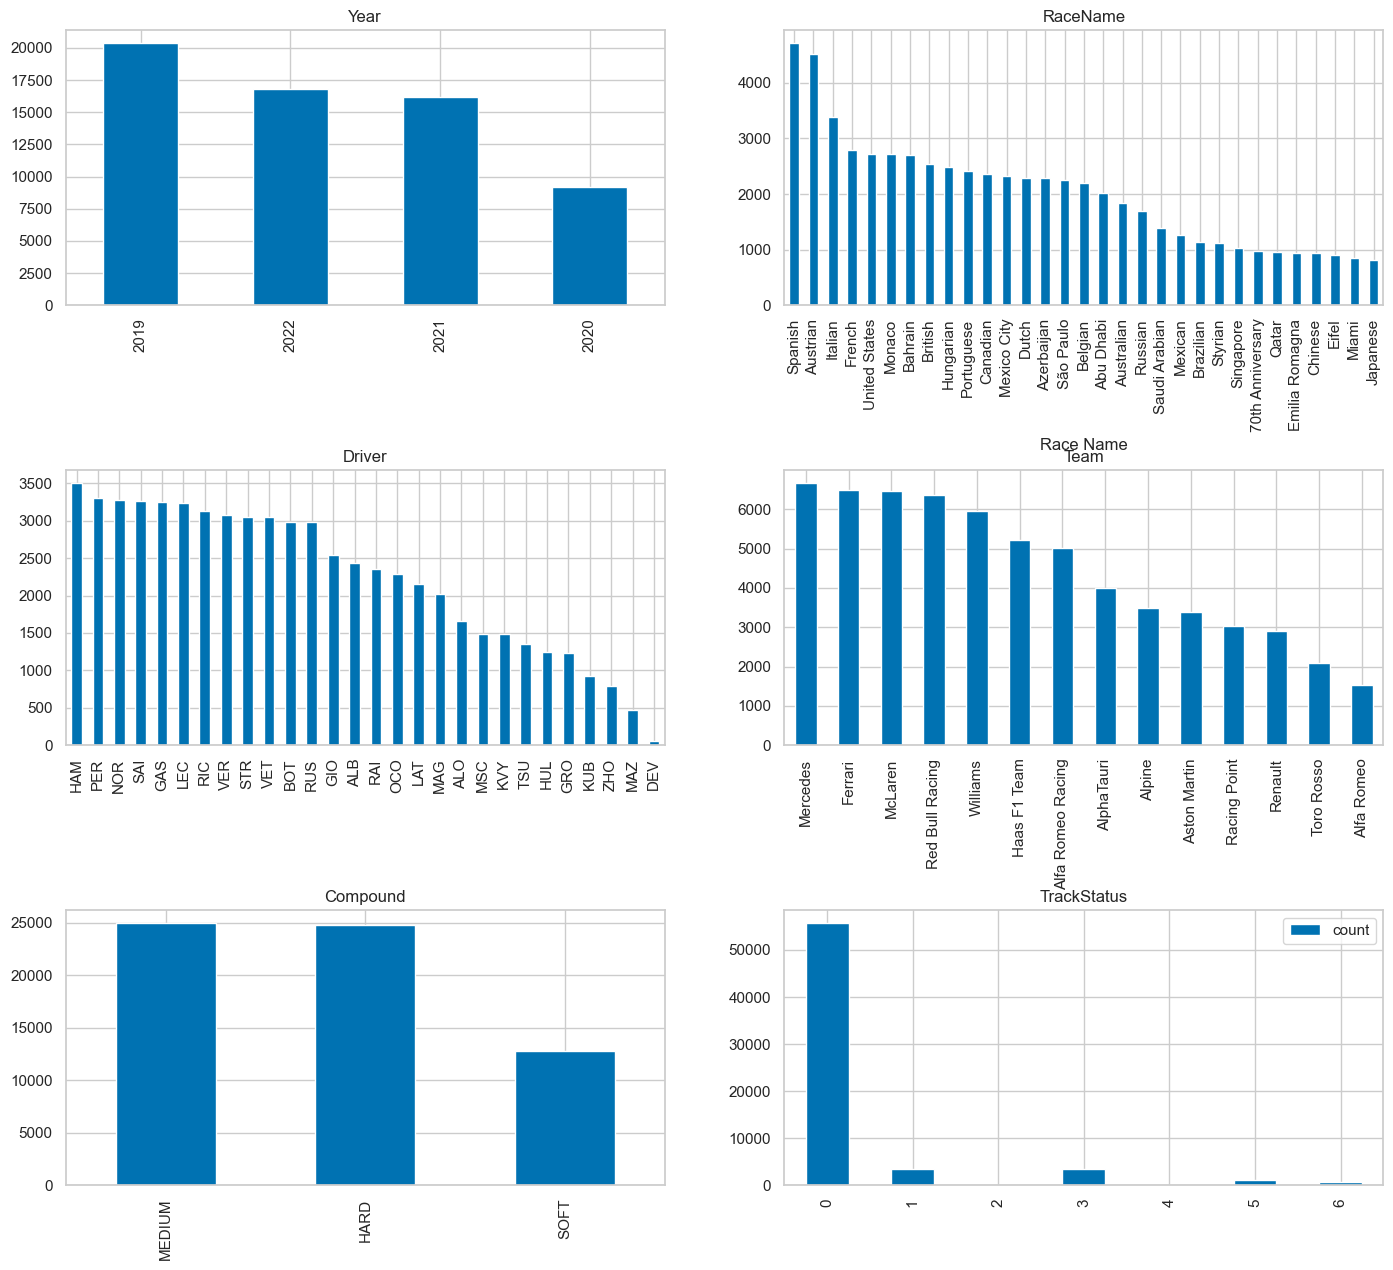

In [81]:
# create a new figure with subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(17, 15))

# loop through each categorical variable and plot a bar chart
for col_idx, col in enumerate(v_categorical):
    row_idx, col_idx = np.unravel_index(col_idx, (3,2))
    
    if col == 'RaceName':
        race_names = df[col].str.replace(' Grand Prix', '')
        race_names.value_counts().plot.bar(ax=axes[row_idx,col_idx], color='#0072B2')
        axes[row_idx,col_idx].set_title(col)
        axes[row_idx,col_idx].set_xlabel('Race Name')

    elif col == 'TrackStatus':
        count_trackStatus.plot.bar(ax=axes[row_idx,col_idx], color='#0072B2')
        axes[row_idx,col_idx].set_title(col)
        
    else:
        df[col].value_counts().plot.bar(ax=axes[row_idx,col_idx], color='#0072B2')
        axes[row_idx,col_idx].set_title(col)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2, hspace=0.6)

# display the plot
plt.show()


### Binary

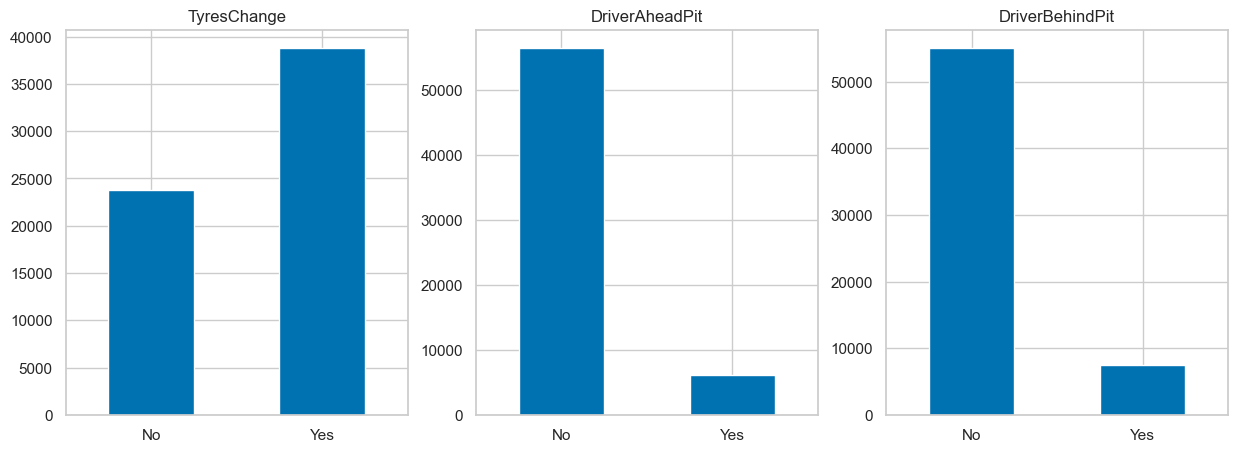

In [82]:
df[v_binary] = df[v_binary].astype(int)
df[v_binary].replace({0: 'No', 1: 'Yes'}).apply(pd.value_counts).plot.bar(subplots=True, layout=(1, 3), figsize=(15,5), color="#0072B2", rot=0, legend=False)
plt.show()


### Numerical

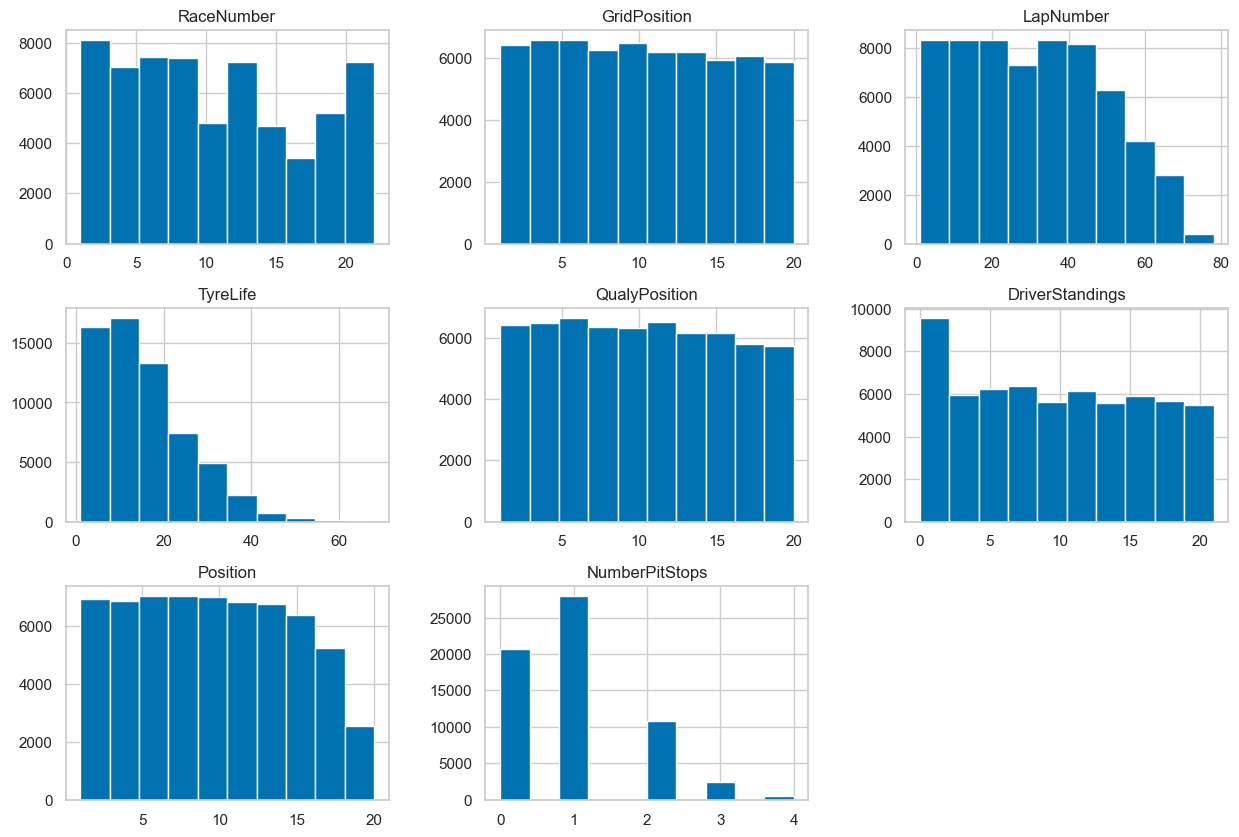

In [83]:
df[v_numerical].hist(layout=(3, 3), figsize=(15,10), color="#0072B2")
plt.show()

### Date

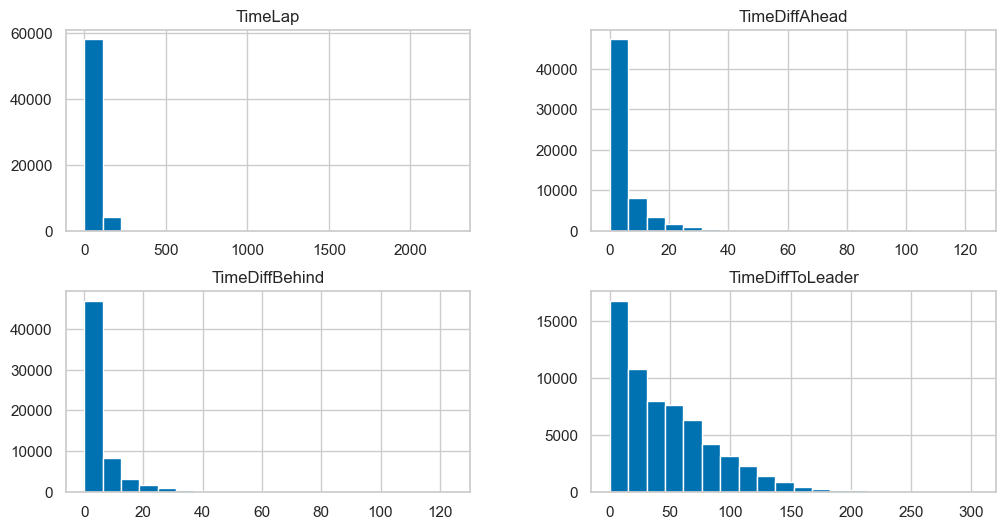

In [84]:
df_time = pd.DataFrame()
df_time['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
df_time['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
df_time['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
df_time['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()

df_time.hist(figsize=(12,6), color="#0072B2", bins=20)
plt.show()

# Data Preprocessing

### Categorical 

In [85]:
def categorical_enc (df):
    v_cat= ['Year', 'RaceName', 'Driver', 'Team', 'Compound']  #TODO

    #Track status
    trackStatus_encoded =  pd.DataFrame()
    df['TrackStatus'] = df['TrackStatus'].astype(str)
    for num in range(1, 8):
        col_name = 'status_' + str(num)
        trackStatus_encoded[col_name] = df['TrackStatus'].str.contains(str(num)).astype(int)
    
    #the rest
    ohe = OneHotEncoder(sparse=False)
    categorical_encoded = pd.DataFrame(ohe.fit_transform(df[v_cat]))
    # Get feature names from encoder and combine with unique values
    feature_names = [f"{col}_{val}" for col, vals in zip(v_cat, v_cat) for val in ohe.categories_[v_cat.index(col)]]
    categorical_encoded.columns = feature_names

    #Combine with track status 
    categorical_encoded = pd.concat([categorical_encoded, trackStatus_encoded], axis=1)
   
    return categorical_encoded

### Binary

In [86]:
def binary_enc (df):
    #It's already encoded, juto convert all to int 
    binary_encoded = df[v_binary].astype(int)
    return binary_encoded

### Numerical

In [87]:
def numerical_enc (df):
    #StandarScaler
    scaler = StandardScaler()
    numerical_encoded = df.groupby(['Year', 'RaceNumber'])[v_numerical].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return numerical_encoded

### Date

In [88]:
def date_enc(df):
    #Convert the times to secods 
    df['TimeLap'] = pd.to_timedelta(df['TimeLap']).dt.total_seconds()
    df['TimeDiffAhead'] = pd.to_timedelta(df['TimeDiffAhead']).dt.total_seconds()
    df['TimeDiffBehind'] = pd.to_timedelta(df['TimeDiffBehind']).dt.total_seconds()
    df['TimeDiffToLeader'] = pd.to_timedelta(df['TimeDiffToLeader']).dt.total_seconds()

    scaler = StandardScaler()
    date_encoded = df.groupby(['Year', 'RaceNumber'])[v_date].apply(lambda x: pd.DataFrame(scaler.fit_transform(x), columns=x.columns, index=x.index))

    return date_encoded

## Enconde

In [89]:
def encode_df (df): 
    categorical_encoded = categorical_enc(df)
    binary_encoded = binary_enc(df)
    numerical_encoded = numerical_enc(df)
    date_encoded = date_enc(df)

    df_encoded = pd.concat([categorical_encoded, binary_encoded, numerical_encoded, date_encoded], axis=1)
    return df_encoded

In [90]:
df_encoded = encode_df (df)
df_encoded

,Year_2019,Year_2020,Year_2021,Year_2022,RaceName_70th Anniversary Grand Prix,RaceName_Abu Dhabi Grand Prix,RaceName_Australian Grand Prix,RaceName_Austrian Grand Prix,RaceName_Azerbaijan Grand Prix,RaceName_Bahrain Grand Prix,...,LapNumber,TyreLife,QualyPosition,DriverStandings,Position,NumberPitStops,TimeLap,TimeDiffAhead,TimeDiffBehind,TimeDiffToLeader
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.701740,-1.211369,-1.377895,0.000000,-1.584317,-1.297384,-7.226051,-0.680778,-0.544589,-1.288219
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.641308,-1.119913,-1.377895,0.000000,-1.584317,-1.297384,0.433598,-0.680778,-0.539114,-1.288219
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.580875,-1.028457,-1.377895,0.000000,-1.584317,-1.297384,0.094677,-0.680778,-0.534259,-1.288219
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.520442,-0.937001,-1.377895,0.000000,-1.584317,-1.297384,0.060711,-0.680778,-0.525058,-1.288219
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.460009,-0.845545,-1.377895,0.000000,-1.584317,-1.297384,0.011314,-0.680778,-0.516308,-1.288219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62561,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.422559,1.393083,1.027476,0.473854,1.469650,0.158780,0.148638,2.296950,4.485850,2.794199
62562,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.482647,1.509222,1.027476,0.473854,1.469650,0.158780,0.173930,2.100669,5.030943,2.911249
62563,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.542735,1.625362,1.027476,0.473854,1.469650,0.158780,0.204790,2.095820,9.828378,3.001758
62564,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.602824,1.741502,1.027476,0.473854,1.286434,0.158780,0.164386,1.638832,-0.795083,3.095589


In [46]:
df_encoded.to_csv("data/encoded_data.csv", index=False, header=True, sep ='\t')